In [ ]:
%cd ../

In [3]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%%capture
import numpy as np
import pandas as pd
import os
from collections import Counter

import rdkit as rd
from rdkit import DataStructs
from rdkit.Chem import AllChem

import sklearn as sk
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import random
import joblib
import shutil

import torch
from torch.utils.data import Dataset, DataLoader
from toxicity.model import MTDNN

import tensorflow as tf
import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

2024-05-04 16:55:47.134107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 16:55:47.325276: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 16:55:48.307293: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-04 16:55:48.307375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [33]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter('tensorboard/')

random_seed = 124
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

morgan_bits = 4096
morgan_radius = 2
train_epoch = 50
batch = 512

In [34]:
clintox_task = ['CT_TOX']
tox21_tasks = ['NR-AR', 'NR-Aromatase', 'NR-PPAR-gamma', 'SR-HSE', 
               'NR-AR-LBD', 'NR-ER', 'SR-ARE', 'SR-MMP',
               'NR-AhR', 'NR-ER-LBD', 'SR-ATAD5', 'SR-p53']

all_tasks = tox21_tasks + clintox_task 

In [35]:
data_path = "./data/toxicity/datasets/tox21/split_data/seed_124/"
train_data=torch.load(data_path + 'train_data_tox21.pth')
test_data=torch.load(data_path + 'test_data_tox21.pth')
valid_data=torch.load(data_path + 'valid_data_tox21.pth')

clintox_data_path = "./data/toxicity/datasets/clintox/split_data/seed_124/"
train_data_clintox=torch.load(clintox_data_path + 'train_data_clintox.pth')
test_data_clintox=torch.load(clintox_data_path + 'test_data_clintox.pth')
valid_data_clintox=torch.load(clintox_data_path + 'valid_data_clintox.pth')

train_data = train_data.merge(train_data_clintox, how='outer', on='smiles')
test_data  = test_data.merge(test_data_clintox, how='outer', on='smiles')
valid_data  = valid_data.merge(valid_data_clintox, how='outer', on='smiles')


data = [train_data, test_data, valid_data]

In [36]:
smiles_embed = torch.load("./data/toxicity/smiles_embedding/smiles_embed_pretrain.pt")
for i in range(len(data)):
    data[i]['smiles_embed'] = data[i]['smiles'].apply(lambda x: smiles_embed.get(x))

In [37]:
data[0] = data[0].fillna(-1)
data[1] = data[1].fillna(-1)
data[2] = data[2].fillna(-1)

In [38]:
train_data = data[0]
test_data  = data[1]
valid_data = data[2]

In [39]:
x_train = []
for tensor in train_data['smiles_embed']:
    x_train.append(tensor)

x_train = torch.stack(x_train)
x_train = x_train.numpy()

y_train = train_data[all_tasks].values

In [40]:
x_test = []

for tensor in test_data['smiles_embed']:
    x_test.append(tensor)
x_test = torch.stack(x_test)
x_test = x_test.numpy()

y_test = test_data[all_tasks].values

In [41]:
x_valid = []
for tensor in valid_data['smiles_embed']:
    x_valid.append(tensor)
x_valid = torch.stack(x_valid)
x_valid = x_valid.numpy()

    
y_valid = valid_data[all_tasks].values

In [42]:
N_train = np.sum(y_train >= 0, 0)
N_test  = np.sum(y_test >= 0, 0)
N_valid  = np.sum(y_valid >= 0, 0)

In [43]:
x_train_torch = x_train.astype(np.float32)
y_train_torch = y_train.astype(np.float32)

x_test_torch = x_test.astype(np.float32)
y_test_torch = y_test.astype(np.float32)

x_valid_torch = x_valid.astype(np.float32)
y_valid_torch = y_valid.astype(np.float32)

input_shape = x_train_torch.shape[1]

In [44]:
class MTDNNData(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [45]:
training_set = MTDNNData(x_train_torch, y_train_torch)
training_generator = DataLoader(training_set, batch_size=batch, shuffle=True)

testing_set = MTDNNData(x_test_torch, y_test_torch)
testing_generator = DataLoader(testing_set, batch_size=len(testing_set), shuffle=False)

valid_set = MTDNNData(x_valid_torch, y_valid_torch)
valid_generator = DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

In [46]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    # Method from : https://gist.github.com/vsay01/45dfced69687077be53dbdd4987b6b17
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)
        
def load_ckp(checkpoint_fpath, input_model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    input_model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    train_loss_min = checkpoint['train_loss_min']
    return model, optimizer, checkpoint['epoch'], train_loss_min.item()

In [47]:
ckpt_path = "./checkpoints/toxicity"

if not os.path.exists(ckpt_path):
    os.mkdir(ckpt_path)

checkpoint_file= ckpt_path + '/current_checkpoint.pt'
bestmodel_file = ckpt_path + '/best_model.pt'  
bestmodel_byvalid_file = ckpt_path + '/best_model_by_valid.pt' 
bestmodel_byvalid_crossed_file = ckpt_path + '/best_model_by_valid-crossed.pt'   

In [48]:
criterion = torch.nn.BCELoss()
model = MTDNN(input_shape, all_tasks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
loss_history=[]  
correct_history=[]  
val_loss_history=[]  
val_correct_history=[] 
train_loss_min = np.Inf
val_loss_min = np.Inf

for e in range(train_epoch):
    
    model.train()

    running_train_loss = 0
    running_valid_loss = 0
    running_train_correct = 0
    running_val_correct = 0
    y_train_true = []
    y_train_pred = []
    y_valid_true = []
    y_valid_pred = []
    batch = 0
    for x_batch, y_batch in training_generator:
        batch += 1
        if torch.cuda.is_available():
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda() 
        
        y_pred = model(x_batch)
        
        # Compute loss over all tasks
        loss = 0
        correct = 0
        y_train_true_task = []
        y_train_pred_task = []
        for i in range(len(all_tasks)):
            y_batch_task = y_batch[:,i]
            y_pred_task  = y_pred[i][:,0]
            
            indice_valid = y_batch_task >= 0
            loss_task = criterion(y_pred_task[indice_valid], y_batch_task[indice_valid]) / N_train[i]
            
            loss += loss_task

            pred_train = np.round(y_pred_task[indice_valid].detach().cpu().numpy())
            target_train = y_batch_task[indice_valid].float()
            y_train_true.extend(target_train.tolist()) 
            y_train_pred.extend(pred_train.reshape(-1).tolist())

        writer.add_scalar("Accuracy/train", loss, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        running_train_loss += loss.item()
        writer.add_scalar("Loss/train", running_train_loss, e)
        
    else:
        with torch.no_grad():    
        ## evaluation part 
            model.eval()
            for val_x_batch, val_y_batch in valid_generator:
                
                if torch.cuda.is_available():
                    val_x_batch, val_y_batch = val_x_batch.cuda(), val_y_batch.cuda() 
                
                val_output = model(val_x_batch)

                ## 2. loss calculation over all tasks 
                val_loss = 0
                val_correct = 0
                y_valid_true_task = []
                y_valid_pred_task = []
                for i in range(len(all_tasks)):
                    val_y_batch_task = val_y_batch[:,i]
                    val_output_task  = val_output[i][:,0]

                    # compute loss for labels that are not NA
                    indice_valid = val_y_batch_task >= 0
                    val_loss_task = criterion(val_output_task[indice_valid], val_y_batch_task[indice_valid]) / N_valid[i]

                    val_loss += val_loss_task
                    
                    pred_valid = np.round(val_output_task[indice_valid].detach().cpu().numpy())
                    target_valid = val_y_batch_task[indice_valid].float()
                    y_valid_true.extend(target_valid.tolist()) 
                    y_valid_pred.extend(pred_valid.reshape(-1).tolist())
                

                running_valid_loss+=val_loss.item()
                writer.add_scalar("Loss/valid", running_valid_loss, e)
        
        #epoch loss
        train_epoch_loss=np.mean(running_train_loss)
        val_epoch_loss=np.mean(running_valid_loss)  
       
        #epoch accuracy     
        train_epoch_acc = accuracy_score(y_train_true,y_train_pred)
        val_epoch_acc = accuracy_score(y_valid_true,y_valid_pred)
        
        #history
        loss_history.append(train_epoch_loss)  
        correct_history.append(train_epoch_acc)
        val_loss_history.append(val_epoch_loss)  
        val_correct_history.append(val_epoch_acc)  
        
        print(f"Epoch: {e}, Training loss: {train_epoch_loss:.4f}, Valid loss: {val_epoch_loss:.4f}")
        
        checkpoint = {
            'epoch': e + 1,
            'train_loss_min': train_epoch_loss,
            'val_loss_min': val_epoch_loss, 
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_ckp(checkpoint, False, checkpoint_file, bestmodel_file)
        
        if train_epoch_loss <= train_loss_min:
            save_ckp(checkpoint, True, checkpoint_file, bestmodel_file)
            train_loss_min = train_epoch_loss
            
        if train_epoch_loss >= val_epoch_loss:
            save_ckp(checkpoint, True, checkpoint_file, bestmodel_byvalid_crossed_file)
            train_loss_min = train_epoch_loss
            
        if val_epoch_loss <= val_loss_min:
            save_ckp(checkpoint, True, checkpoint_file, bestmodel_file)
            val_loss_min = val_epoch_loss

Epoch: 0, Training loss: 0.0173, Valid loss: 0.0081
Epoch: 1, Training loss: 0.0078, Valid loss: 0.0048
Epoch: 2, Training loss: 0.0062, Valid loss: 0.0048
Epoch: 3, Training loss: 0.0051, Valid loss: 0.0041
Epoch: 4, Training loss: 0.0043, Valid loss: 0.0044
Epoch: 5, Training loss: 0.0036, Valid loss: 0.0049
Epoch: 6, Training loss: 0.0031, Valid loss: 0.0049
Epoch: 7, Training loss: 0.0026, Valid loss: 0.0050
Epoch: 8, Training loss: 0.0022, Valid loss: 0.0054
Epoch: 9, Training loss: 0.0019, Valid loss: 0.0053


In [24]:
loaded_model, optimizer, start_epoch, train_loss_min = load_ckp(bestmodel_file, model, optimizer)

In [27]:
for x_test_torch, y_test_torch in testing_generator:
    y_test_pred = loaded_model.eval().to(device).cpu()(x_test_torch)
    
    # Compute loss over all tasks
    loss = 0
    for i in range(len(all_tasks)):
        y_test_task = y_test_torch[:,i]
        y_pred_task  = y_test_pred[i][:,0]

        # compute loss for labels that are not NA
        indice_valid = y_test_task >= 0
        loss_task = criterion(y_pred_task[indice_valid], y_test_task[indice_valid]) / N_test[i]

        loss += loss_task
    
print(loss.item())

0.008896548300981522


Accuracy for MTDNN on Morgan Fingerprint: 0.963855421686747
F1 for MTDNN on Morgan Fingerprint: 0.49056603773584906
 True Positive: 0.43333333333333335
 True Negative: 0.9860529986052998
False Positive: 0.01394700139470014
False Negative: 0.5666666666666667
Test ROC AUC (NR-AR): 0.7668526266852627


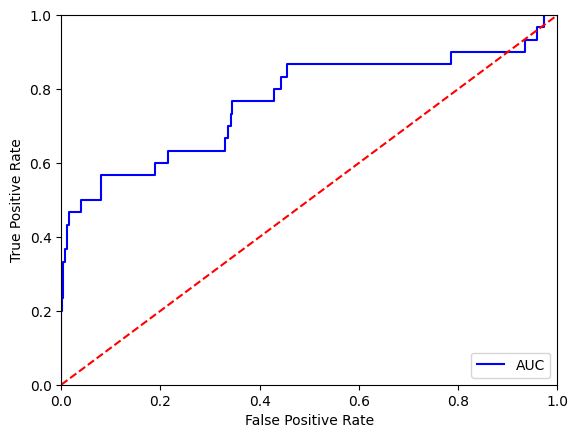

Accuracy for MTDNN on Morgan Fingerprint: 0.9362416107382551
F1 for MTDNN on Morgan Fingerprint: 0.3870967741935484
 True Positive: 0.35294117647058826
 True Negative: 0.9715302491103203
False Positive: 0.028469750889679714
False Negative: 0.6470588235294118
Test ROC AUC (NR-Aromatase): 0.7904542599958132


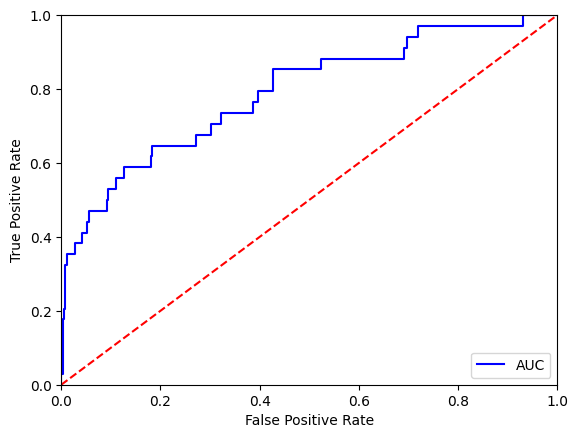

Accuracy for MTDNN on Morgan Fingerprint: 0.9643387815750372
F1 for MTDNN on Morgan Fingerprint: 0.0
 True Positive: 0.0
 True Negative: 0.9848254931714719
False Positive: 0.015174506828528073
False Negative: 1.0
Test ROC AUC (NR-PPAR-gamma): 0.709733362237156


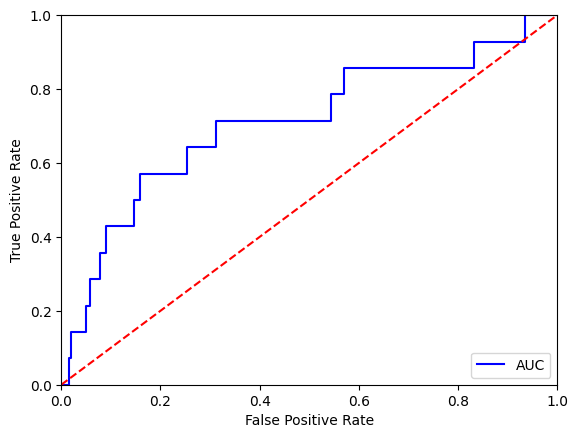

Accuracy for MTDNN on Morgan Fingerprint: 0.9333333333333333
F1 for MTDNN on Morgan Fingerprint: 0.26229508196721313
 True Positive: 0.2222222222222222
 True Negative: 0.97339593114241
False Positive: 0.026604068857589983
False Negative: 0.7777777777777778
Test ROC AUC (SR-HSE): 0.8218135976351939


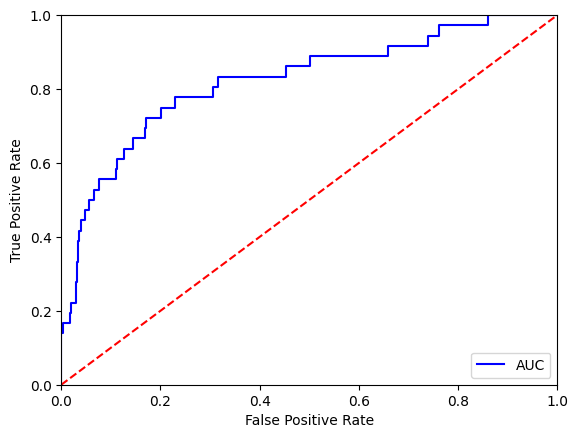

Accuracy for MTDNN on Morgan Fingerprint: 0.9773691654879774
F1 for MTDNN on Morgan Fingerprint: 0.5294117647058824
 True Positive: 0.5294117647058824
 True Negative: 0.9884057971014493
False Positive: 0.011594202898550725
False Negative: 0.47058823529411764
Test ROC AUC (NR-AR-LBD): 0.8723785166240409


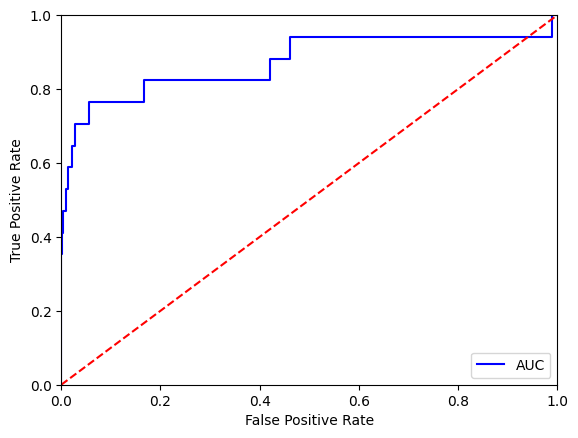

Accuracy for MTDNN on Morgan Fingerprint: 0.8591117917304747
F1 for MTDNN on Morgan Fingerprint: 0.4177215189873418
 True Positive: 0.3402061855670103
 True Negative: 0.9496402877697842
False Positive: 0.050359712230215826
False Negative: 0.6597938144329897
Test ROC AUC (NR-ER): 0.6802454943261886


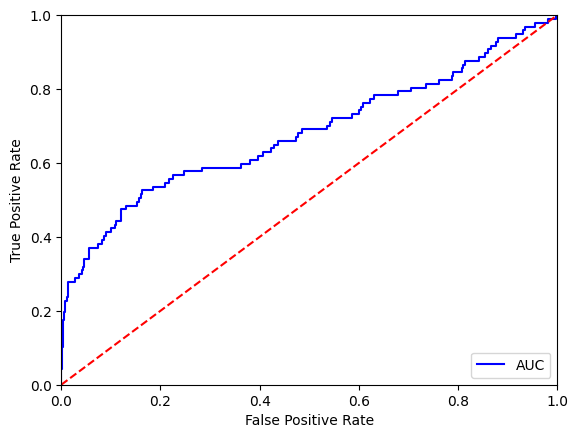

Accuracy for MTDNN on Morgan Fingerprint: 0.8486394557823129
F1 for MTDNN on Morgan Fingerprint: 0.47337278106508873
 True Positive: 0.4166666666666667
 True Negative: 0.9329268292682927
False Positive: 0.06707317073170732
False Negative: 0.5833333333333334
Test ROC AUC (SR-ARE): 0.7710873983739837


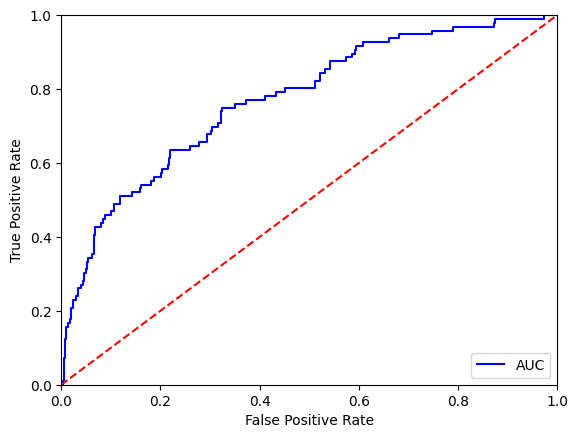

Accuracy for MTDNN on Morgan Fingerprint: 0.8917089678510999
F1 for MTDNN on Morgan Fingerprint: 0.6404494382022472
 True Positive: 0.6
 True Negative: 0.9475806451612904
False Positive: 0.05241935483870968
False Negative: 0.4
Test ROC AUC (SR-MMP): 0.8358870967741936


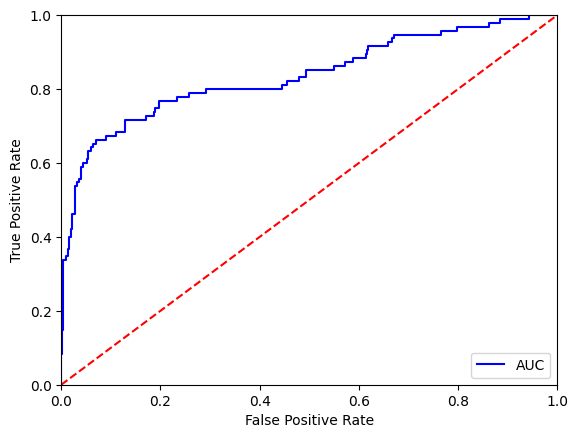

Accuracy for MTDNN on Morgan Fingerprint: 0.9113737075332349
F1 for MTDNN on Morgan Fingerprint: 0.589041095890411
 True Positive: 0.5375
 True Negative: 0.9614740368509213
False Positive: 0.038525963149078725
False Negative: 0.4625
Test ROC AUC (NR-AhR): 0.871859296482412


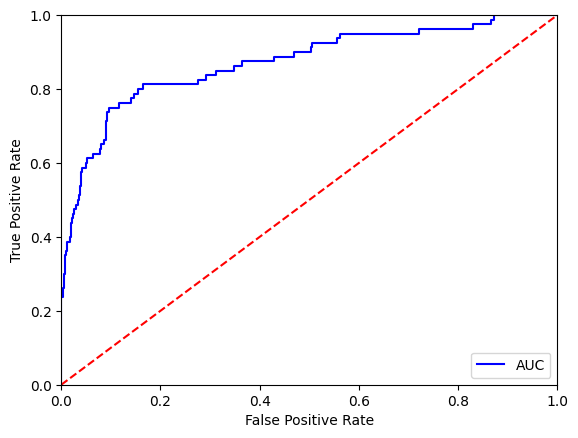

Accuracy for MTDNN on Morgan Fingerprint: 0.9585062240663901
F1 for MTDNN on Morgan Fingerprint: 0.6052631578947368
 True Positive: 0.5227272727272727
 True Negative: 0.9867452135493373
False Positive: 0.013254786450662739
False Negative: 0.4772727272727273
Test ROC AUC (NR-ER-LBD): 0.8219975900388271


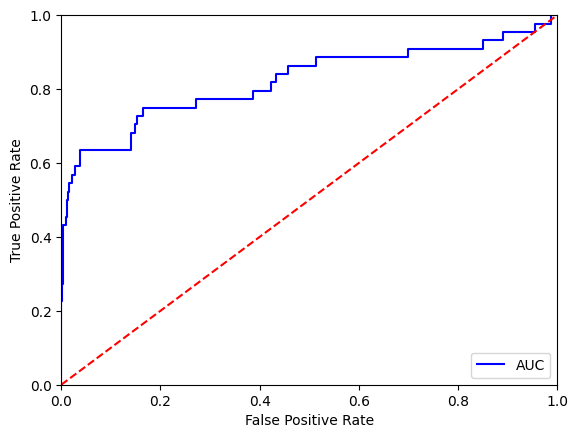

Accuracy for MTDNN on Morgan Fingerprint: 0.9661246612466124
F1 for MTDNN on Morgan Fingerprint: 0.28571428571428575
 True Positive: 0.20833333333333334
 True Negative: 0.9915966386554622
False Positive: 0.008403361344537815
False Negative: 0.7916666666666666
Test ROC AUC (SR-ATAD5): 0.7054738562091504


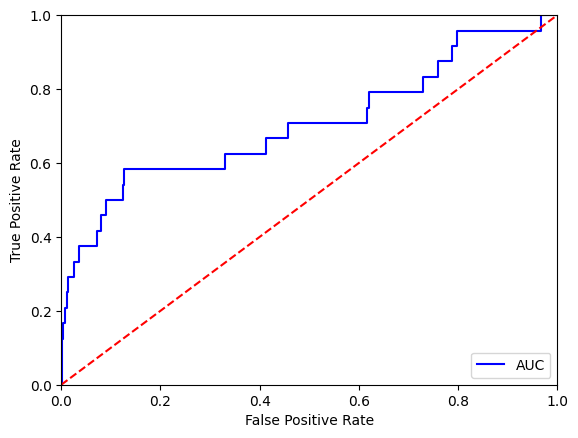

Accuracy for MTDNN on Morgan Fingerprint: 0.9321789321789322
F1 for MTDNN on Morgan Fingerprint: 0.31884057971014496
 True Positive: 0.24444444444444444
 True Negative: 0.9799382716049383
False Positive: 0.020061728395061727
False Negative: 0.7555555555555555
Test ROC AUC (SR-p53): 0.7886831275720164


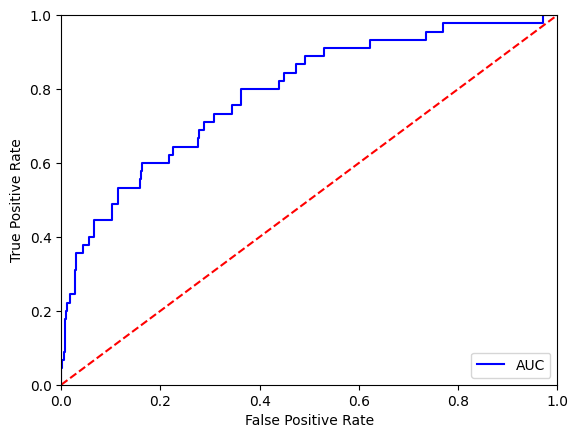

Accuracy for MTDNN on Morgan Fingerprint: 0.9594594594594594
F1 for MTDNN on Morgan Fingerprint: 0.7000000000000001
 True Positive: 0.875
 True Negative: 0.9642857142857143
False Positive: 0.03571428571428571
False Negative: 0.125
Test ROC AUC (CT_TOX): 0.9330357142857143


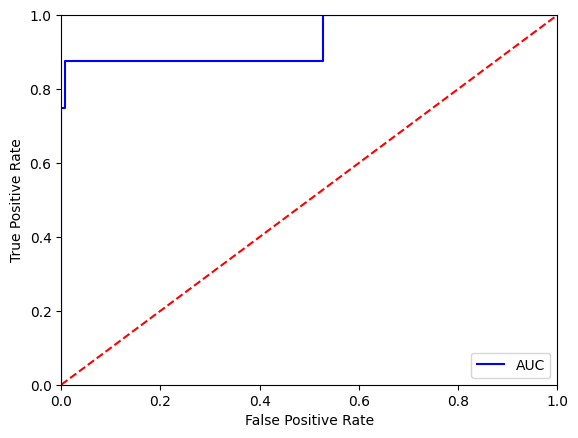

In [28]:
results = {}
# Collects performance metrics for all tasks on test set
for i in range(len(all_tasks)):
    
    valid_datapoints = y_test[:,i] >= 0
    y_test_task = y_test[valid_datapoints,i] 
    y_test_pred_task = y_test_pred[i].detach().numpy()[valid_datapoints,0]
    
    acc = accuracy_score(y_test_task, np.round(y_test_pred_task))
    print('Accuracy for MTDNN on Morgan Fingerprint:', acc)
    
    bacc = sk.metrics.balanced_accuracy_score(y_test_task, np.round(y_test_pred_task))

    f1 = f1_score(y_test_task, np.round(y_test_pred_task), pos_label=1)
    print('F1 for MTDNN on Morgan Fingerprint:', f1)

    cfm = sk.metrics.confusion_matrix(y_test_task, np.round(y_test_pred_task))
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]
    
    tn, fp, fn, tp = cfm.ravel()
    pr = tp / (tp + fp)
    rc = tp / (tp + fn)
    print(' True Positive:', tp)
    print(' True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    
    auc = roc_auc_score(y_test_task, y_test_pred_task)
    print('Test ROC AUC ({}):'.format(all_tasks[i]), auc)
    
    results[all_tasks[i]] = [auc, acc, bacc, tn, tp, pr, rc, f1]

    fpr, tpr, threshold = sk.metrics.roc_curve(y_test_task, y_test_pred_task)
    plt.plot(fpr, tpr, 'b', label = 'AUC')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [29]:
print('Task'.ljust(10), '\t', '  AUC ', ' ACC ', ' BACC ', ' TN  ', ' TP  ', ' PR  ', ' RC  ', ' F1  ')
for task, auc in results.items():
    print(task.ljust(10), '\t', np.round(auc,3))

Task       	   AUC   ACC   BACC   TN    TP    PR    RC    F1  
NR-AR      	 [0.767 0.964 0.71  0.986 0.433 0.969 0.433 0.491]
NR-Aromatase 	 [0.79  0.936 0.662 0.972 0.353 0.925 0.353 0.387]
NR-PPAR-gamma 	 [0.71  0.964 0.492 0.985 0.    0.    0.    0.   ]
SR-HSE     	 [0.822 0.933 0.598 0.973 0.222 0.893 0.222 0.262]
NR-AR-LBD  	 [0.872 0.977 0.759 0.988 0.529 0.979 0.529 0.529]
NR-ER      	 [0.68  0.859 0.645 0.95  0.34  0.871 0.34  0.418]
SR-ARE     	 [0.771 0.849 0.675 0.933 0.417 0.861 0.417 0.473]
SR-MMP     	 [0.836 0.892 0.774 0.948 0.6   0.92  0.6   0.64 ]
NR-AhR     	 [0.872 0.911 0.749 0.961 0.538 0.933 0.538 0.589]
NR-ER-LBD  	 [0.822 0.959 0.755 0.987 0.523 0.975 0.523 0.605]
SR-ATAD5   	 [0.705 0.966 0.6   0.992 0.208 0.961 0.208 0.286]
SR-p53     	 [0.789 0.932 0.612 0.98  0.244 0.924 0.244 0.319]
CT_TOX     	 [0.933 0.959 0.92  0.964 0.875 0.961 0.875 0.7  ]


In [30]:
# print test loss
for x_valid_torch, y_valid_torch in valid_generator:
    y_valid_pred = model.eval().to(device).cpu()(x_valid_torch)
    
    # Compute loss over all tasks
    loss = 0
    for i in range(len(all_tasks)):
        y_test_task = y_valid_torch[:,i]
        y_pred_task  = y_valid_pred[i][:,0]

        # compute loss for labels that are not NA
        indice_valid = y_test_task >= 0
        loss_task = criterion(y_pred_task[indice_valid], y_test_task[indice_valid]) / N_test[i]

        loss += loss_task
    
print(loss.item())

0.007743715774267912


Accuracy for deepnn on Morgan Fingerprint: 0.9635135135135136
F1 for deepnn on Morgan Fingerprint: 0.5423728813559322
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.98725212 0.01274788]
 [0.52941176 0.47058824]]
 True Positive: 0.47058823529411764
 True Negative: 0.9872521246458924
False Positive: 0.012747875354107648
False Negative: 0.5294117647058824
Test ROC AUC (NR-AR): 0.8567738710214965


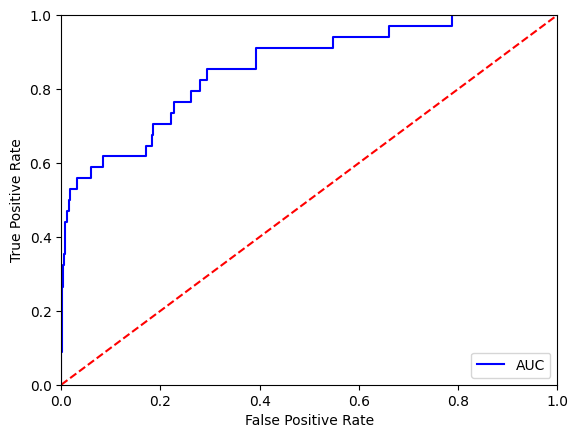

Accuracy for deepnn on Morgan Fingerprint: 0.9292929292929293
F1 for deepnn on Morgan Fingerprint: 0.3225806451612903
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.96441281 0.03558719]
 [0.6875     0.3125    ]]
 True Positive: 0.3125
 True Negative: 0.9644128113879004
False Positive: 0.03558718861209965
False Negative: 0.6875
Test ROC AUC (NR-Aromatase): 0.7233652135231318


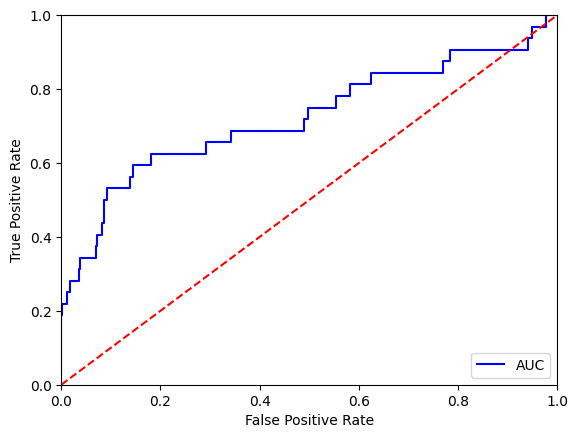

Accuracy for deepnn on Morgan Fingerprint: 0.9668174962292609
F1 for deepnn on Morgan Fingerprint: 0.3125
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.98757764 0.01242236]
 [0.73684211 0.26315789]]
 True Positive: 0.2631578947368421
 True Negative: 0.9875776397515528
False Positive: 0.012422360248447204
False Negative: 0.7368421052631579
Test ROC AUC (NR-PPAR-gamma): 0.8949820202680614


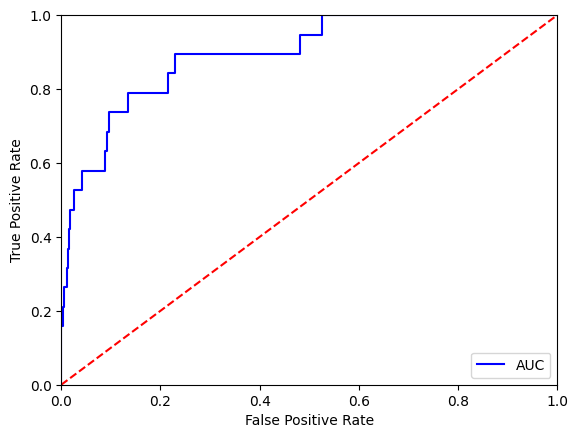

Accuracy for deepnn on Morgan Fingerprint: 0.9264264264264265
F1 for deepnn on Morgan Fingerprint: 0.26865671641791045
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.97124601 0.02875399]
 [0.775      0.225     ]]
 True Positive: 0.225
 True Negative: 0.9712460063897763
False Positive: 0.02875399361022364
False Negative: 0.775
Test ROC AUC (SR-HSE): 0.716573482428115


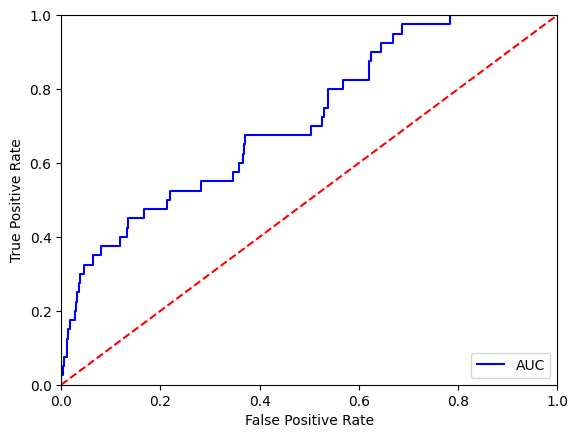

Accuracy for deepnn on Morgan Fingerprint: 0.9709302325581395
F1 for deepnn on Morgan Fingerprint: 0.6296296296296297
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.98338369 0.01661631]
 [0.34615385 0.65384615]]
 True Positive: 0.6538461538461539
 True Negative: 0.9833836858006042
False Positive: 0.01661631419939577
False Negative: 0.34615384615384615
Test ROC AUC (NR-AR-LBD): 0.884731582616779


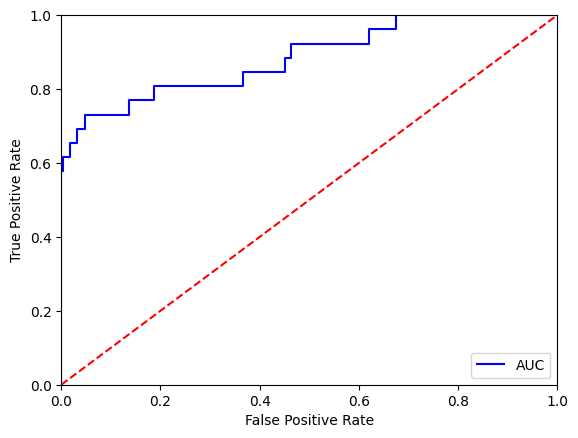

Accuracy for deepnn on Morgan Fingerprint: 0.853035143769968
F1 for deepnn on Morgan Fingerprint: 0.41025641025641024
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.92449355 0.07550645]
 [0.61445783 0.38554217]]
 True Positive: 0.3855421686746988
 True Negative: 0.9244935543278084
False Positive: 0.07550644567219153
False Negative: 0.6144578313253012
Test ROC AUC (NR-ER): 0.7310901062814794


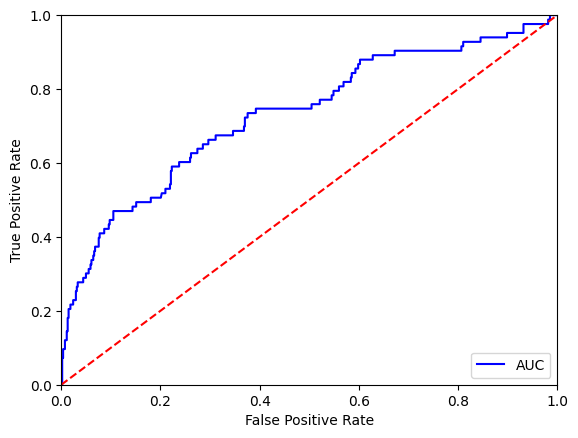

Accuracy for deepnn on Morgan Fingerprint: 0.8394648829431438
F1 for deepnn on Morgan Fingerprint: 0.4352941176470589
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.93186373 0.06813627]
 [0.62626263 0.37373737]]
 True Positive: 0.37373737373737376
 True Negative: 0.9318637274549099
False Positive: 0.06813627254509018
False Negative: 0.6262626262626263
Test ROC AUC (SR-ARE): 0.7827979190704641


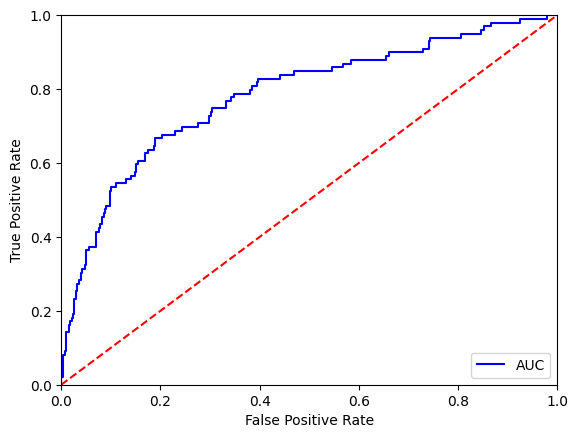

Accuracy for deepnn on Morgan Fingerprint: 0.8900169204737732
F1 for deepnn on Morgan Fingerprint: 0.644808743169399
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.937751  0.062249 ]
 [0.3655914 0.6344086]]
 True Positive: 0.6344086021505376
 True Negative: 0.9377510040160643
False Positive: 0.06224899598393574
False Negative: 0.3655913978494624
Test ROC AUC (SR-MMP): 0.8649220538066243


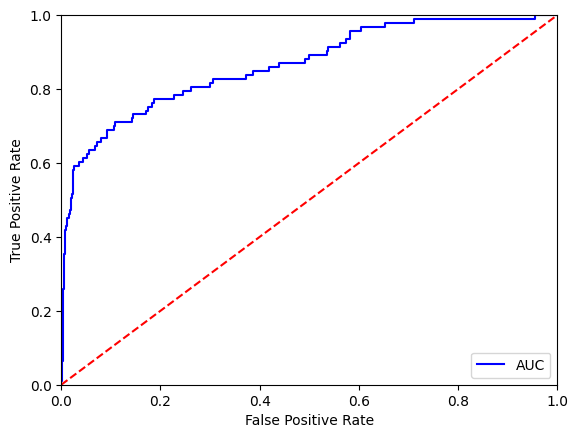

Accuracy for deepnn on Morgan Fingerprint: 0.9019316493313522
F1 for deepnn on Morgan Fingerprint: 0.5074626865671641
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.95341098 0.04658902]
 [0.52777778 0.47222222]]
 True Positive: 0.4722222222222222
 True Negative: 0.9534109816971714
False Positive: 0.04658901830282862
False Negative: 0.5277777777777778
Test ROC AUC (NR-AhR): 0.8498336106489184


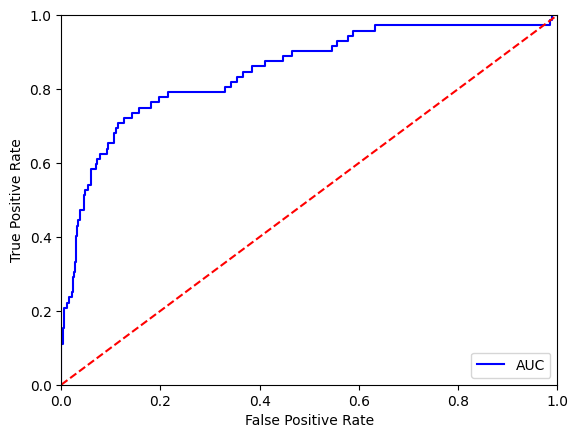

Accuracy for deepnn on Morgan Fingerprint: 0.9430199430199431
F1 for deepnn on Morgan Fingerprint: 0.4736842105263158
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.97428139 0.02571861]
 [0.56097561 0.43902439]]
 True Positive: 0.43902439024390244
 True Negative: 0.9742813918305597
False Positive: 0.025718608169440244
False Negative: 0.5609756097560976
Test ROC AUC (NR-ER-LBD): 0.8170916202354156


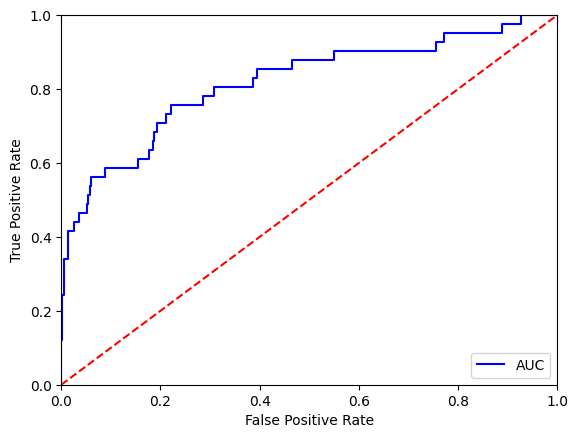

Accuracy for deepnn on Morgan Fingerprint: 0.9595536959553695
F1 for deepnn on Morgan Fingerprint: 0.21621621621621623
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.98417266 0.01582734]
 [0.81818182 0.18181818]]
 True Positive: 0.18181818181818182
 True Negative: 0.9841726618705036
False Positive: 0.015827338129496403
False Negative: 0.8181818181818182
Test ROC AUC (SR-ATAD5): 0.7429692609548725


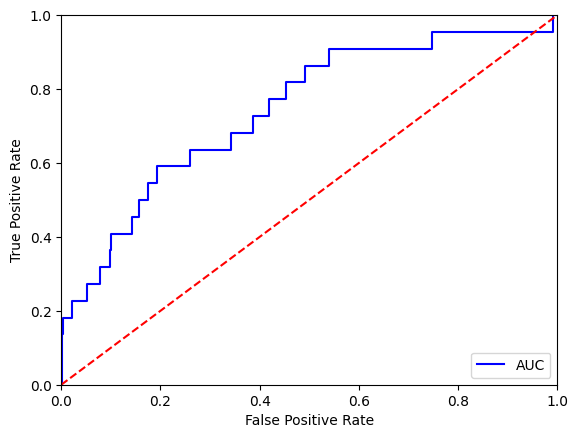

Accuracy for deepnn on Morgan Fingerprint: 0.9257142857142857
F1 for deepnn on Morgan Fingerprint: 0.35
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.96060606 0.03939394]
 [0.65       0.35      ]]
 True Positive: 0.35
 True Negative: 0.9606060606060606
False Positive: 0.03939393939393939
False Negative: 0.65
Test ROC AUC (SR-p53): 0.8094318181818181


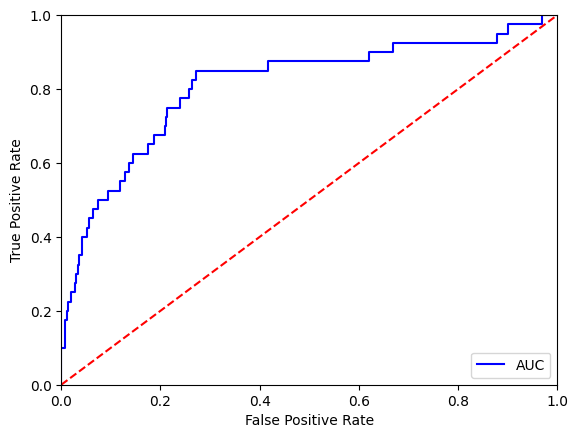

Accuracy for deepnn on Morgan Fingerprint: 0.9798657718120806
F1 for deepnn on Morgan Fingerprint: 0.8571428571428572
Confusion Matrix for deepnn on Morgan Fingerprint:
 [[0.98561151 0.01438849]
 [0.1        0.9       ]]
 True Positive: 0.9
 True Negative: 0.9856115107913669
False Positive: 0.014388489208633094
False Negative: 0.1
Test ROC AUC (CT_TOX): 0.9928057553956835


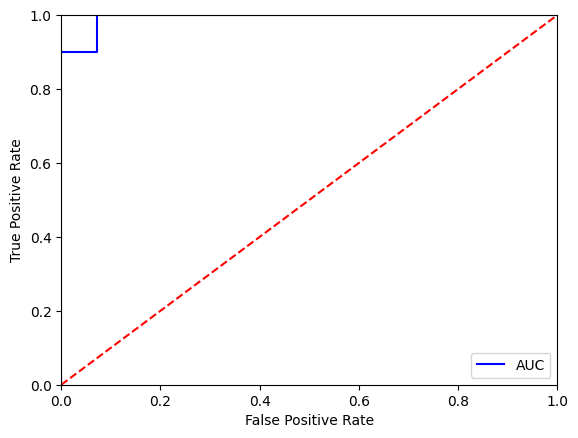

In [31]:
results_valid = {}
# Collects performance metrics for all tasks on Valid set
for i in range(len(all_tasks)):
    
    valid_datapoints = y_valid[:,i] >= 0
    y_valid_task = y_valid[valid_datapoints,i] 
    y_valid_pred_task = y_valid_pred[i].detach().numpy()[valid_datapoints,0]
    
    
    acc = accuracy_score(y_valid_task, np.round(y_valid_pred_task))
    print('Accuracy for deepnn on Morgan Fingerprint:', acc)
    
    bacc = sk.metrics.balanced_accuracy_score(y_valid_task, np.round(y_valid_pred_task))

    f1 = f1_score(y_valid_task, np.round(y_valid_pred_task), pos_label=1)
    print('F1 for deepnn on Morgan Fingerprint:', f1)

    cfm = sk.metrics.confusion_matrix(y_valid_task, np.round(y_valid_pred_task))
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]

    print('Confusion Matrix for deepnn on Morgan Fingerprint:\n', cfm)

    tn, fp, fn, tp = cfm.ravel()
    pr = tp / (tp + fp)
    rc = tp / (tp + fn)
    print(' True Positive:', tp)
    print(' True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    
    auc = roc_auc_score(y_valid_task, y_valid_pred_task)
    print('Test ROC AUC ({}):'.format(all_tasks[i]), auc)
    
    results_valid[all_tasks[i]] = [auc, acc, bacc, tn, tp, pr, rc, f1]

    fpr, tpr, threshold = sk.metrics.roc_curve(y_valid_task, y_valid_pred_task)
    plt.plot(fpr, tpr, 'b', label = 'AUC')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [32]:
print('Task'.ljust(10), '\t', '  AUC ', ' ACC ', ' BACC ', ' TN  ', ' TP  ', ' PR  ', ' RC  ', ' F1  ')
for task, auc in results_valid.items():
    print(task.ljust(10), '\t', np.round(auc,3))

Task       	   AUC   ACC   BACC   TN    TP    PR    RC    F1  
NR-AR      	 [0.857 0.964 0.729 0.987 0.471 0.974 0.471 0.542]
NR-Aromatase 	 [0.723 0.929 0.638 0.964 0.312 0.898 0.312 0.323]
NR-PPAR-gamma 	 [0.895 0.967 0.625 0.988 0.263 0.955 0.263 0.312]
SR-HSE     	 [0.717 0.926 0.598 0.971 0.225 0.887 0.225 0.269]
NR-AR-LBD  	 [0.885 0.971 0.819 0.983 0.654 0.975 0.654 0.63 ]
NR-ER      	 [0.731 0.853 0.655 0.924 0.386 0.836 0.386 0.41 ]
SR-ARE     	 [0.783 0.839 0.653 0.932 0.374 0.846 0.374 0.435]
SR-MMP     	 [0.865 0.89  0.786 0.938 0.634 0.911 0.634 0.645]
NR-AhR     	 [0.85  0.902 0.713 0.953 0.472 0.91  0.472 0.507]
NR-ER-LBD  	 [0.817 0.943 0.707 0.974 0.439 0.945 0.439 0.474]
SR-ATAD5   	 [0.743 0.96  0.583 0.984 0.182 0.92  0.182 0.216]
SR-p53     	 [0.809 0.926 0.655 0.961 0.35  0.899 0.35  0.35 ]
CT_TOX     	 [0.993 0.98  0.943 0.986 0.9   0.984 0.9   0.857]
